In [9]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import requests
import joblib


In [11]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [13]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from PIL import Image
from wordcloud import WordCloud,  ImageColorGenerator

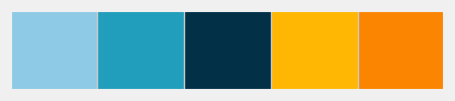

In [23]:
style.use("fivethirtyeight")
colors = ["#8ecae6", "#219ebc", "#023047", "#ffb703", "#fb8500"]
palette = sns.color_palette(colors)
sns.palplot(sns.color_palette(colors))
plt.show()
style.use("fivethirtyeight")

In [27]:
data = pd.read_csv('train.csv', header=None)
data.head(10)

,0,1
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...
5,5,Top notch doctor in a top notch practice. Can'...
6,5,Dr. Eric Goldberg is a fantastic doctor who ha...
7,1,I'm writing this review to give you a heads up...
8,2,Wing sauce is like water. Pretty much a lot of...
9,3,Decent range somewhat close to the city. The ...


In [29]:
data.shape


(650000, 2)

In [49]:
data.columns = ["Sentiments", "Review"]
data.head()

,Sentiments,Review
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [51]:
def sentiment(label):
    if label<3:
        return "Negative"
    elif label>3:
        return "Positive"
    else:
        return "Neutral"

In [53]:
data['Sentiment'] = data["Sentiments"].apply(sentiment)
data.head(10)

,Sentiments,Review,Sentiment
0,5,dr. goldberg offers everything i look for in a...,Positive
1,2,"Unfortunately, the frustration of being Dr. Go...",Negative
2,4,Been going to Dr. Goldberg for over 10 years. ...,Positive
3,4,Got a letter in the mail last week that said D...,Positive
4,1,I don't know what Dr. Goldberg was like before...,Negative
5,5,Top notch doctor in a top notch practice. Can'...,Positive
6,5,Dr. Eric Goldberg is a fantastic doctor who ha...,Positive
7,1,I'm writing this review to give you a heads up...,Negative
8,2,Wing sauce is like water. Pretty much a lot of...,Negative
9,3,Decent range somewhat close to the city. The ...,Neutral


In [55]:
data.shape


(650000, 3)

In [57]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentiments  650000 non-null  int64 
 1   Review      650000 non-null  object
 2   Sentiment   650000 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.9+ MB


In [59]:
data.value_counts("Sentiment")

Sentiment
Negative    260000
Positive    260000
Neutral     130000
Name: count, dtype: int64

C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\2359462227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])


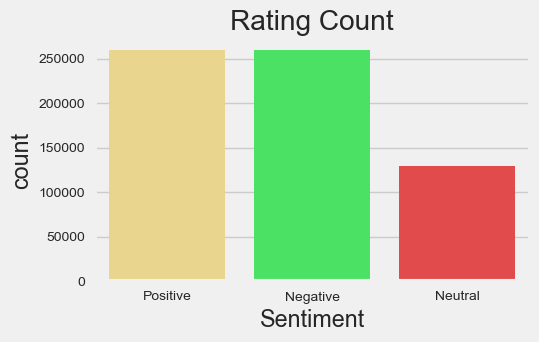

In [61]:
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])
plt.title("Rating Count")
plt.show()

In [69]:
data["Sentiment"].value_counts()/len(data)


Sentiment
Positive    0.4
Negative    0.4
Neutral     0.2
Name: count, dtype: float64

In [71]:
data.isna().sum()


Sentiments    0
Review        0
Sentiment     0
dtype: int64

In [73]:
text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()
text_len.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\2468471289.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()


,Range,Review
0,"(0, 500]",303849
1,"(500, 1000]",194749
2,"(1000, 1500]",82198
3,"(1500, 2000]",35626
4,"(2000, 2500]",16476


In [75]:
text_len_50 = text_len[text_len['Review'] > 50]
text_len_50

,Range,Review
0,"(0, 500]",303849
1,"(500, 1000]",194749
2,"(1000, 1500]",82198
3,"(1500, 2000]",35626
4,"(2000, 2500]",16476
5,"(2500, 3000]",8003
6,"(3000, 3500]",4003
7,"(3500, 4000]",2122
8,"(4000, 4500]",1292
9,"(4500, 5000]",1230


C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\4000903183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\4000903183.py:2: UserWarning: 
The palette list has fewer values (5) than needed (40) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\4000903183.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


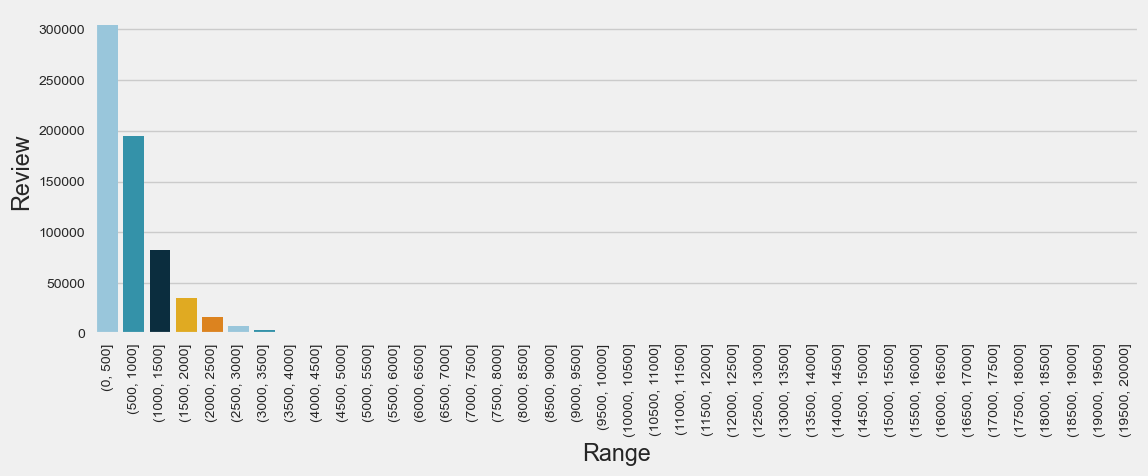

In [77]:
plt.figure(figsize=(12, 4))
g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_8892\1778809724.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)


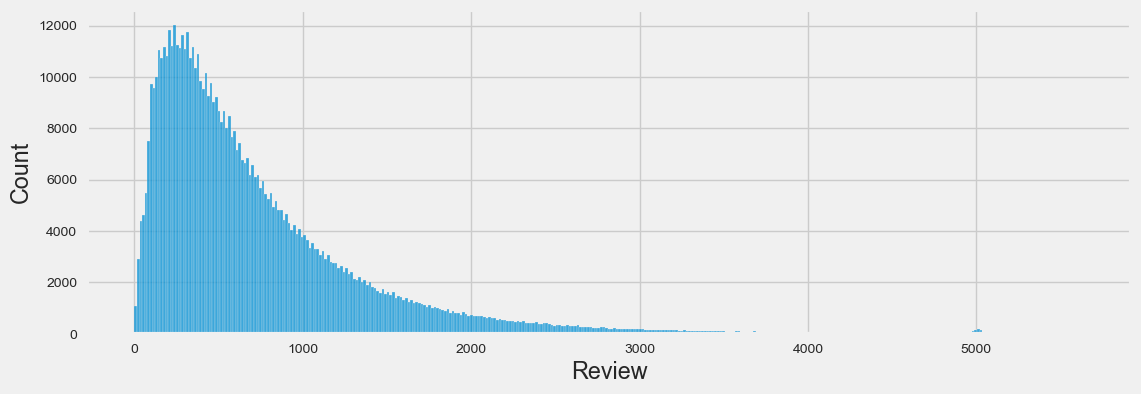

In [79]:
plt.figure(figsize=(12, 4))
sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)
plt.show()

In [81]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.97)
for train_index, test_index in split.split(data, data["Sentiment"]):
    strat_data = data.reindex(train_index)

In [83]:
strat_data.head(10)


,Sentiments,Review,Sentiment
357508,3,This is a useful little post office and the fi...,Neutral
162575,2,This Casino is old. I really needs a remodel. ...,Negative
356300,3,Great atmosphere. A bit pricey in my opinion....,Neutral
633635,1,I'd love to try this plate but 3/3 times they'...,Negative
136805,5,This place is AWESOME AWESOME AWESOME. We are...,Positive
425520,5,Love this place! Don't forget the to start w...,Positive
139254,5,"Three words: Brad, Brady and Jake. The best b...",Positive
572462,2,We decided to try this place out as we had rec...,Negative
646352,3,We have been to the SLS a couple times since i...,Neutral
605414,5,What's a girl to do when she walks bleary eyed...,Positive


In [85]:
strat_data.shape

(19500, 3)

In [87]:
strat_data.value_counts("Sentiment")


Sentiment
Negative    7800
Positive    7800
Neutral     3900
Name: count, dtype: int64

In [89]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [91]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', ' ', text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lem_tokens)

In [93]:
preprocess_text(data["Review"][2])

'going dr goldberg year think one st patient started mhmg great year really big picture former gyn dr markoff found fibroid explores option patient understanding judge asks right question thorough want kept loop every aspect medical health life'

In [95]:
preprocess_text(data["Review"][110])

'starbucks teeny tiny n nseating inside limited starbucks grab go continue shopping waterfront n nbaristas friendly fast'

In [97]:
strat_data["Review"] = strat_data["Review"].apply(preprocess_text)
strat_data.head(10)

,Sentiments,Review,Sentiment
357508,3,useful little post office first port call wish...,Neutral
162575,2,casino old really need remodel connected tram ...,Negative
356300,3,great atmosphere bit pricey opinion drink over...,Neutral
633635,1,love try plate time closed sold doughnut espec...,Negative
136805,5,place awesome awesome awesome montana get vega...,Positive
425520,5,love place forget start pretzel,Positive
139254,5,three word brad brady jake best bartender vega...,Positive
572462,2,decided try place received mailer ayce dinner ...,Negative
646352,3,sl couple time since first opened local wanted...,Neutral
605414,5,girl walk bleary eyed bellagio find room ready...,Positive


In [99]:
txt = "".join(strat_data["Review"].tolist())

In [101]:
len(txt)

8526515

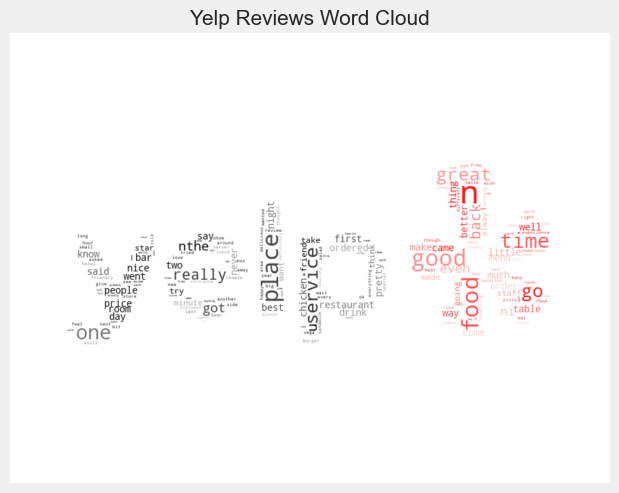

In [107]:
yelp_mask = np.array(Image.open(requests.get('https://logowik.com/content/uploads/images/yelp4226.jpg', stream=True).raw))

wc = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=yelp_mask).generate(txt)
image_colors = ImageColorGenerator(amazon_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.title("Yelp Reviews Word Cloud", fontsize = 15)
plt.savefig('wordcloud.png')
plt.show()

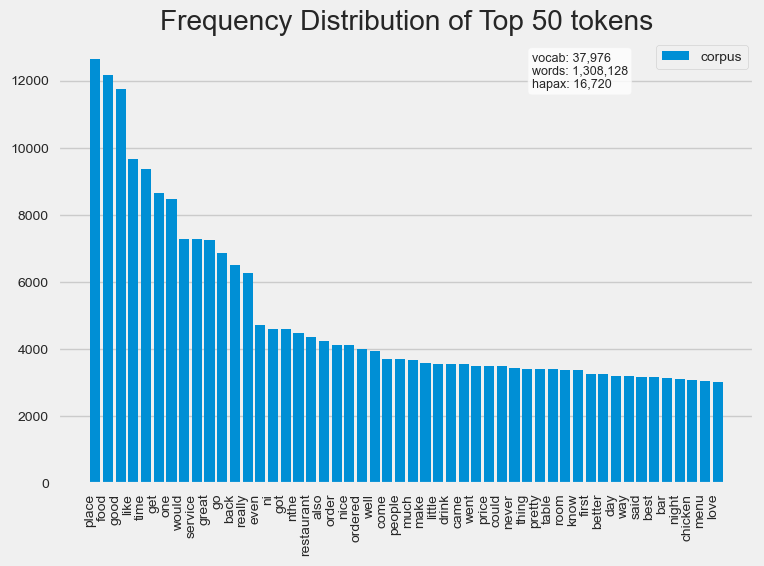

In [111]:
def word_distribution(text):
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()

    # Freq Dist Visualizer
    visualizer = FreqDistVisualizer(features=features, orient='v')
    visualizer.fit(docs)
    visualizer.show()

word_distribution(strat_data['Review'])

In [113]:
	tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))

In [115]:
X_tfidf = tfidf_vectorizer.fit_transform(strat_data['Review'])
X_tfidf

<19500x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1053357 stored elements in Compressed Sparse Row format>

In [117]:
X_tfidf.shape

(19500, 5000)

In [119]:
y = strat_data["Sentiment"]

In [121]:
y.shape

(19500,)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42,test_size = 0.20)

In [125]:
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(X_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")

(15600, 5000)
Number of Training Samples: 15600
(15600,)
Number of Training Samples: 15600
(3900, 5000)
Number of Training Samples: 15600
(3900,)
Number of Training Samples: 15600


In [127]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [129]:
LogisticRegression()

LogisticRegression()

In [131]:
predictedLogReg = logreg.predict(X_test)
np.mean(predictedLogReg == y_test)

0.7592307692307693

In [133]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
logreg.predict(inp_test)

Enter review:  i don't like this restuarant


i don't like this restuarant
After preprocessing:  like restuarant


array(['Negative'], dtype=object)

In [135]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(y_test, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.78      0.86      0.81      1595
     Neutral       0.56      0.35      0.43       769
    Positive       0.80      0.86      0.83      1536

    accuracy                           0.76      3900
   macro avg       0.71      0.69      0.69      3900
weighted avg       0.74      0.76      0.74      3900

Accuracy: 0.7592307692307693


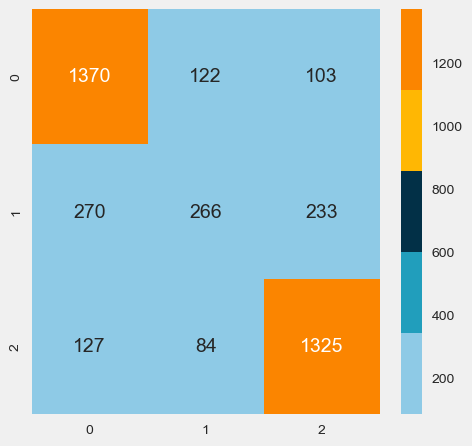

In [137]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test,predictedLogReg), annot=True, fmt="d", cmap=colors)
plt.show()

In [139]:
cm = confusion_matrix(y_test,predictedLogReg)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1370  122  103]
 [ 270  266  233]
 [ 127   84 1325]]

True Positives(TP) =  1370

True Negatives(TN) =  266

False Positives(FP) =  122

False Negatives(FN) =  270


In [141]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [143]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of LG: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of LG: 0.8067


In [145]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of LG: {0:0.4f}'.format(classification_error))

Classification error of LG: 0.1933


In [147]:
precision = TP / float(TP + FP)
print('Precision of LG: {0:0.4f}'.format(precision))

Precision of LG: 0.9182


In [149]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of LG: {0:0.4f}'.format(recall))

Recall or Sensitivity of LG: 0.8354


In [151]:
y_pred_prob = logreg.predict_proba(X_test)[0:10]
y_pred_prob

array([[0.11578595, 0.75038724, 0.13382681],
       [0.90205699, 0.06495971, 0.03298329],
       [0.73094672, 0.11157312, 0.15748015],
       [0.33510216, 0.21864351, 0.44625433],
       [0.25897613, 0.62755247, 0.1134714 ],
       [0.15781341, 0.1241321 , 0.71805449],
       [0.3104864 , 0.38728473, 0.30222887],
       [0.06122707, 0.22297888, 0.71579405],
       [0.70224483, 0.09632194, 0.20143323],
       [0.68650241, 0.19213468, 0.12136291]])

In [153]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - Negative (0)', 'Prob of - Neutral (1)', 'Prob of - Positive (2)'])
y_pred_prob_df

,Prob of - Negative (0),Prob of - Neutral (1),Prob of - Positive (2)
0,0.115786,0.750387,0.133827
1,0.902057,0.064960,0.032983
2,0.730947,0.111573,0.157480
3,0.335102,0.218644,0.446254
4,0.258976,0.627552,0.113471
5,0.157813,0.124132,0.718054
6,0.310486,0.387285,0.302229
7,0.061227,0.222979,0.715794
8,0.702245,0.096322,0.201433
9,0.686502,0.192135,0.121363


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.20)

In [157]:
print(f"Training:\n X = {X_train.shape}\n y = {y_train.shape}")
print(f"Testing:\n X = {X_test.shape}\n y = {y_test.shape}")

Training:
 X = (15600, 5000)
 y = (15600,)
Testing:
 X = (3900, 5000)
 y = (3900,)


In [159]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [163]:
y_pred = svm.predict(X_test)

In [164]:
accuracy_score(y_test, y_pred)*100

75.28205128205127

In [167]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
svm.predict(inp_test)

Enter review:  this food is good


this food is good
After preprocessing:  food good


array(['Neutral'], dtype=object)

In [169]:
print("Classification Report")
print(f"{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.77      0.85      0.81      1595
     Neutral       0.54      0.38      0.45       769
    Positive       0.80      0.84      0.82      1536

    accuracy                           0.75      3900
   macro avg       0.71      0.69      0.69      3900
weighted avg       0.74      0.75      0.74      3900

Accuracy: 0.7528205128205128


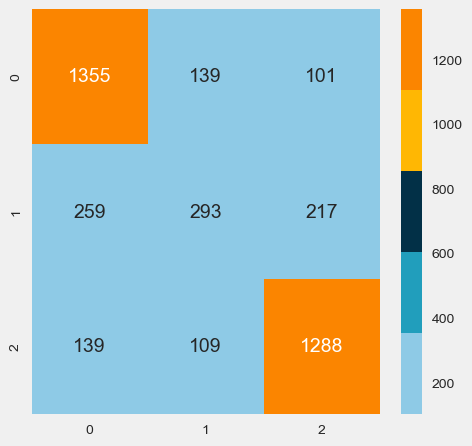

In [171]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap=colors)
plt.show()

In [173]:
	cm = confusion_matrix(y_test, y_pred)

	print('Confusion matrix\n\n', cm)
	print('\nTrue Positives(TP) = ', cm[0,0])
	print('\nTrue Negatives(TN) = ', cm[1,1])
	print('\nFalse Positives(FP) = ', cm[0,1])
	print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1355  139  101]
 [ 259  293  217]
 [ 139  109 1288]]

True Positives(TP) =  1355

True Negatives(TN) =  293

False Positives(FP) =  139

False Negatives(FN) =  259


In [175]:
print('\nFalse Negatives(FN) = ', cm[1,0])
#%%
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


False Negatives(FN) =  259


In [177]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of SVM: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of SVM: 0.8055


In [179]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of SVM: {0:0.4f}'.format(classification_error))

Classification error of SVM: 0.1945


In [181]:
precision = TP / float(TP + FP)
print('Precision of SVM: {0:0.4f}'.format(precision))

Precision of SVM: 0.9070


In [183]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of SVM: {0:0.4f}'.format(recall))

Recall or Sensitivity of SVM: 0.8395


In [185]:
pi = {'vectorizer': tfidf_vectorizer, 'logreg': logreg, 'svm': svm}
pickle.dump(pi, open('models' + '.p', 'wb'))